In [1]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
import math

### 1. Computing Histograms

In [2]:
def compute_image_histogram(gray_image, number_bins):
    '''Computes histogram for an input image
    Parameters:
    ---
    gray_image - input image on gray scale that the histogram will be computed for
    number_bins - number of bins in the histogram
    ---
    '''
    width = 256/number_bins
    hist = np.zeros(number_bins)
    
    #checking image shape
    if (len(gray_image.shape) > 2):
        gray_image = gray_image[:,:,0]
    else:
        gray_image = gray_image
    
    #counting pixels and adding to histogram
    for y in range(gray_image.shape[0]):
        for x in range(gray_image.shape[1]):
            pixel_val = gray_image[y,x]
            pixel_val = int(pixel_val)
            bin_num = int(pixel_val/width)
            hist[bin_num] += 1
    return hist

In [3]:
#test the above function
#compare the results with using numpy.histogram()
img = imageio.imread('5/TRAIN087283.JPG')

histogram_self = compute_image_histogram(img, 16)
np_histogram, bins = np.histogram(img, bins=16, range=[0,256])

C:\Users\ameli\AppData\Local\Temp\ipykernel_16316\3493824733.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread('5/TRAIN087283.JPG')


Text(0.5, 1.0, 'Histogram From numpy.histogram()')

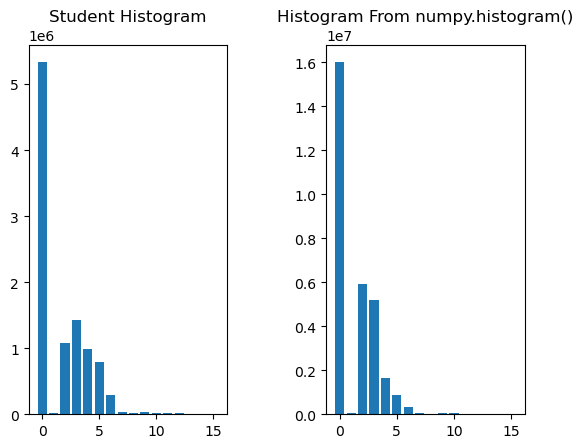

In [4]:
#plotting the two different histograms produced by the two different functions
fig, ax = plt.subplots(1, 2)
plt.subplots_adjust(wspace=0.5)

ax[0].bar(range(len(histogram_self)), histogram_self)
ax[0].set_title('Student Histogram')
ax[1].bar(range(len(np_histogram)), np_histogram)
ax[1].set_title('Histogram From numpy.histogram()')

### 2. Histogram Equlization

In [5]:
def equalize_histogram(gray_image):
    '''function designed to equalize the histogram of a provided image
    
    Parameters
    ---
    gray_image - provided image to create histogram and perform histogram equalization
    ---
    '''
    
    #checking image shape
    if (len(gray_image.shape) > 2):
        gray_image = gray_image[:,:,0]
    else:
        gray_image = gray_image
        
    #Compute image histogram and histogram cdf
    hist, bins = np.histogram(gray_image, bins=256, range=[0,256])
    cdf = np.cumsum(hist)
    
    #normalizing cdf and generating equalization map
    height, width = gray_image.shape
    norm_cdf = cdf / (height * width)
    mapping = (norm_cdf * 255).astype('uint8')
    
    #equalized image
    img_eq = mapping[img]
    
    return img_eq

In [6]:
def compute_hist_cdf(gray_image):
    '''function created to
    1. compute image histogram
    2. compute histogram cdf
    3. display the histogram and cdf of the image
    
    Parameters:
    ---
    img - image to be used for computing histogram and cdf
    ---
    '''
    #checking image shape
    if (len(gray_image.shape) > 2):
        gray_image = gray_image[:,:,0]
    else:
        gray_image = gray_image
        
    height, width = gray_image.shape
        
    #Compute image histogram and histogram cdf
    hist, bins = np.histogram(gray_image, bins=256, range=[0,256])
    cdf = np.cumsum(hist)
    norm_cdf = cdf/(height*width)
    
    return hist, norm_cdf, bins

C:\Users\ameli\AppData\Local\Temp\ipykernel_16316\1672819153.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread('5/TRAIN087283.JPG')


Text(0.5, 1.0, 'Equalized Image')

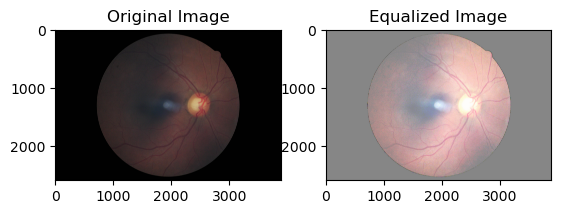

In [8]:
#Testing the equalization of the histogram for image
img = imageio.imread('5/TRAIN087283.JPG')
img_eq = equalize_histogram(img)

#displaying the original image versus the equalized image
fig, ax = plt.subplots(1,2)
ax[0].imshow(img, cmap = 'Greens')
ax[0].set_title("Original Image")
ax[1].imshow(img_eq, cmap = 'Greens')
ax[1].set_title("Equalized Image")

Text(0.5, 1.0, 'Equalized Histogram')

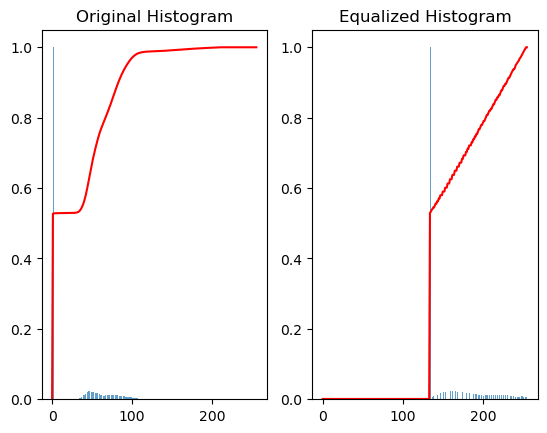

In [9]:
#displaying histograms for image before and after equalization with cdf displayed
og_hist, og_cdf, og_bins = compute_hist_cdf(img)
eq_hist, eq_cdf, eq_bins = compute_hist_cdf(img_eq)

og_center = (og_bins[:-1] + og_bins[1:])/2
eq_center = (eq_bins[:-1] + eq_bins[1:])/2

fig, ax = plt.subplots(1,2)

ax[0].bar(og_center, og_hist / og_hist.max(), align = 'center', alpha = 0.7)
ax[0].plot(og_cdf, color = 'red')
ax[0].set_title('Original Histogram')

ax[1].bar(eq_center, eq_hist / eq_hist.max(), align = 'center', alpha = 0.7)
ax[1].plot(eq_cdf, color = 'red')
ax[1].set_title('Equalized Histogram')

### 3.Threshold Computation

In [10]:
'''
Description of the Otsu's method for threshold computation
Step 1. create a histogram of pixel values

Instructions:
-Apply the identified threshold to an image for threshoulding
-Verify the computed thresholds by plotting the histogram and overlaid vertical
 line at the threshold value
'''

def otsu_threshold(hist):
    '''
    function to apply Otsu's method of thresholding to a given image histogram
    
    Parameters:
    ---
    hist - histogram of a given image
    ---
    '''
    
    #step 1 - estimate probability of pixel value in the image
    total_pix = hist.sum() #obtain total number of pixels
    norm_hist = hist/total_pix #probability of each pixel value
    
    #step 2 - obtain mean value of all image pixels
    mu_T = 0
    for n in range(len(hist)):
        mu_T += n * norm_hist[n]
     
    #step 3 initialze aray to store all between-class variances
    variances = np.zeros(256)
    
    #step 4 Go through all possible threshold value
    for k in range(256):
        w0 = 0
        for i in range(k+1):
            w0 += norm_hist[i]
        w1 = 1 - w0
        
        mu0 = 0
        if w0 != 0: #added because w0 is a divisor and cannot be 0
            for i in range(k+1):
                mu0 += 1/w0*(i * norm_hist[i])
            
        mu1 = 0
        if w1 != 0: #added because w1 is a divisor and cannot be 0
            for i in range(k+1, 256):
                mu1 += 1/w1*(i * norm_hist[i])
                
        #compute and record between-class variance
        between_class_variance = w0 * ((mu0 - mu_T)**2) + w1*((mu1 - mu_T)**2)
        variances[k] = between_class_variance
        
    k_max = np.argmax(variances)
    
    return k_max
    

C:\Users\ameli\AppData\Local\Temp\ipykernel_14764\54049688.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread('5/TRAIN087283.JPG')


threshold is 25


Text(0.5, 1.0, 'Image after applying Threshold')

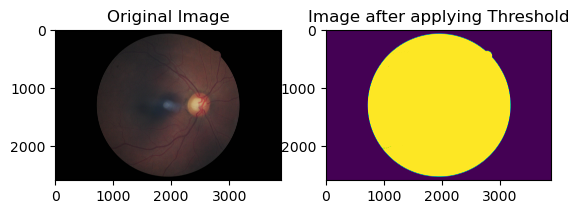

In [25]:
#computing threshold for an image and applying to image
img = imageio.imread('5/TRAIN087283.JPG')
hist = compute_image_histogram(img[:, :, 1], 256)
threshold = otsu_threshold(hist)
print("threshold is", threshold)

#applying threshold to image
image_binary = (img[:, :, 1] > threshold).astype(np.uint8)*255

fig, ax = plt.subplots(1, 2)
ax[0].imshow(img)
ax[0].set_title('Original Image')
ax[1].imshow(image_binary)
ax[1].set_title('Image after applying Threshold')

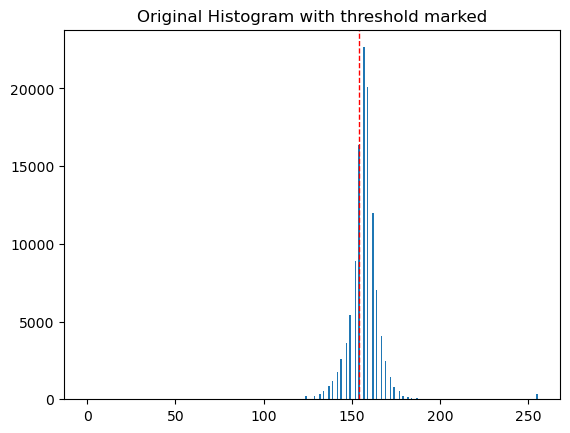

In [11]:
#plotting image histogram with threshold marked
plt.bar(range(len(hist)), hist)
plt.title('Original Histogram with threshold marked')
plt.axvline(x=threshold, color='red', linestyle='dashed', linewidth=1, label='Threshold')